In [1]:
import warnings 
warnings.filterwarnings("ignore")

Cargamos nuestra data
    

In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sa

In [43]:
import pymysql
import pandas as pd

class DatabaseConnection:
    def __init__(
        self,
        username: str = "usuario1",
        password: str = "C0d35p4ce.",
        database: str = "sandbox",
        host: str = "database-1.cjyy8w6ya3FR.eu-north-1.rds.amazonaws.com",
        port: int = 3306,
    ) -> None:
        """
        Creates a connection to a database using pymysql.

        Args:
            username (str): username
            password (str): password
            host (str): host
            port (int): port
            database (str): database
        """
        self.connection = pymysql.connect(
            host=host,
            user=username,
            password=password,
            database=database,
            port=port,
            cursorclass=pymysql.cursors.DictCursor  # To return results as dictionaries
        )

    def query_to_df(self, query: str) -> pd.DataFrame:
        """Executes a SQL query and returns a Pandas DataFrame.

        Args:
            query (str): SQL query string.

        Returns:
            pd.DataFrame: DataFrame containing the query results.
        """
        try:
            with self.connection.cursor() as cursor:
                cursor.execute(query)
                result = cursor.fetchall()
                df = pd.DataFrame(result)
                return df
        except Exception as e:
            print(f"Error executing query: {e}")
            return pd.DataFrame()

    def insert_dataframe(self, dataframe: pd.DataFrame, table_name: str) -> None:
        """Inserts a Pandas DataFrame into a database table.

        Args:
            dataframe (pd.DataFrame): DataFrame to insert.
            table_name (str): Name of the table to insert the data into.
        """
        try:
            with self.connection.cursor() as cursor:
                # Convert DataFrame to a list of tuples
                rows = [tuple(row) for row in dataframe.to_numpy()]
                # Get column names
                columns = ",".join(dataframe.columns)
                # Create placeholders for the values
                placeholders = ",".join(["%s"] * len(dataframe.columns))
                # Create the SQL query
                query = f"INSERT INTO {table_name} ({columns}) VALUES ({placeholders})"
                # Execute the query
                cursor.executemany(query, rows)
                # Commit the transaction
                self.connection.commit()
                print(f"Data inserted successfully into {table_name}")
        except Exception as e:
            print(f"Error inserting data into {table_name}: {e}")
            self.connection.rollback()  # Rollback in case of error

    def close_connection(self):
        """Closes the database connection."""
        if self.connection:
            self.connection.close()

    def check_connection(self) -> bool:
        """Checks if the connection to the database is valid.

        Returns:
            bool: True if the connection is valid, False otherwise.
        """
        try:
            with self.connection.cursor() as cursor:
                cursor.execute("SELECT 1")
            return True
        except Exception as e:
            print(f"Connection failed: {e}")
            return False

In [45]:
# sensitive_data.py
USERNAME = "usuario1"
PASSWORD = "C0d35p4ce."
LOCATION = (36.721477644071705, -4.363132134392174)


In [46]:
# Configura tus credenciales
USERNAME = "usuario1"
PASSWORD = "C0d35p4ce."

# Define tu consulta SQL
query = """
    SELECT familia,
           articulo,
           fecha_venta,
           festivo,
           precio,
           cantidad,
           importe,
           orden_articulo_familia
    FROM at_ventas_diarias_estudio
"""

# Instancia la conexión a la base de datos
database = DatabaseConnection(username=USERNAME, password=PASSWORD)

# Verifica la conexión
if database.check_connection():
    print("Conexión exitosa. Ejecutando la consulta...")

    # Ejecuta la consulta y convierte los resultados a un DataFrame
    df = database.query_to_df(query)

    if not df.empty:
        # Realiza transformaciones en el DataFrame si es necesario
        df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
        df["articulo"] = df["articulo"].astype(int)
        print(df.head())
    else:
        print("La consulta no devolvió resultados.")

    # Cierra la conexión
    database.close_connection()
else:
    print("Error en la conexión a la base de datos.")



Conexión exitosa. Ejecutando la consulta...
    familia  articulo fecha_venta festivo  precio  cantidad     importe  \
0  BOLLERIA      3880  2021-05-01    NULL   2.591   285.000  738.434998   
1  BOLLERIA      3960  2021-05-01    NULL   2.318   402.000  931.835995   
2  BOLLERIA      5803  2021-05-01    NULL   2.727   237.000  646.298981   
3  BOLLERIA      6286  2021-05-01    NULL   3.136   165.000  517.440006   
4  BOLLERIA      6425  2021-05-01    NULL  31.364    31.725  995.022083   

   orden_articulo_familia  
0                       3  
1                       1  
2                       5  
3                       4  
4                       2  


### Filter by Item

We selected the PRODUCT_ID 3960, but we can select any other item.

In [47]:
PRODUCT_FAMILY = "BOLLERIA"
PRODUCT_ID = 3960


item_df = df.copy()
item_df = item_df[item_df["articulo"] == PRODUCT_ID]
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
item_df.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3960,2021-05-01,NULL,2.318,402.0,931.835995,1
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1
3,BOLLERIA,3960,2021-05-04,NULL,2.318,237.0,549.365999,1
4,BOLLERIA,3960,2021-05-05,NULL,2.318,288.0,667.584000,1


## Transformers

### Calendar Transformer

The calendar transformer will perform the following operations:

- 👉 Extract the day
- 👉 Extract the month
- 👉 Extract the year
- 👉 Extract the day of the week
- 👉 Extract the weekend (true/false)
- 👉 Extract the holiday (true/false)

First we add the `day`, `month`, `year`, `dayofweek` and `weekend` columns.

In [7]:
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df["day"] = df[date_column].dt.day
    df["month"] = df[date_column].dt.month
    df["year"] = df[date_column].dt.year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1
    df["isWeekend"] = df["dayofweek"] >= 6
    return df

item_df_tmp = item_df.copy()
add_date_columns(item_df_tmp).head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,day,month,year,dayofweek,isWeekend
0,BOLLERIA,3960,2021-05-01,NULL,2.318,402.0,931.835995,1,1,5,2021,6,True
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,2,5,2021,7,True
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,3,5,2021,1,False
3,BOLLERIA,3960,2021-05-04,NULL,2.318,237.0,549.365999,1,4,5,2021,2,False
4,BOLLERIA,3960,2021-05-05,NULL,2.318,288.0,667.584000,1,5,5,2021,3,False


We add a Holiday Column


In [8]:
def add_holiday_column(df: pd.DataFrame, holiday_column_name: str = "festivo") -> pd.DataFrame:
    df["isHoliday"]  = ~df[holiday_column_name].isna()
    return df

item_df_tmp = item_df.copy()
add_holiday_column(item_df_tmp).head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,isHoliday
0,BOLLERIA,3960,2021-05-01,NULL,2.318,402.0,931.835995,1,True
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,True
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,True
3,BOLLERIA,3960,2021-05-04,NULL,2.318,237.0,549.365999,1,True
4,BOLLERIA,3960,2021-05-05,NULL,2.318,288.0,667.584000,1,True


We add a Calendar Transformer


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin


class CalendarTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        calendar_df = add_date_columns(X)
        calendar_df = add_holiday_column(calendar_df)
        calendar_df = calendar_df[["day", "month", "year", "dayofweek", "isWeekend", "isHoliday"]]
        return calendar_df

Now we transform the data 


In [10]:
item_df_tmp = item_df.copy()
calendar_transformer = CalendarTransformer()
calendar_transformer.transform(item_df_tmp).head()

,day,month,year,dayofweek,isWeekend,isHoliday
0,1,5,2021,6,True,True
1,2,5,2021,7,True,True
2,3,5,2021,1,False,True
3,4,5,2021,2,False,True
4,5,5,2021,3,False,True


## Weather Transformer 


We use the meteostat API to get the weather data. The weather transformer will perform the following operations:

- 👉 Add the weather conditions for the dates in the dataframe
- 👉 Add a `rain` column (true/false)

First we create a function to fetch the weather dataframe.

In [11]:
from datetime import datetime
from meteostat import Point, Daily


def get_weather_data(start: datetime, end: datetime, location: tuple[int, int]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().reset_index()

def merge_by_columns(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
    merged_df.index.name = None
    return merged_df

def add_weather_data(
    df: pd.DataFrame,
    location: tuple[int, int],
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_data(start, end, location)
    weather_df = merge_by_columns(df, weather_df, date_column_name, "time")
    return weather_df

In [12]:
start = item_df["fecha_venta"].min()
end = item_df["fecha_venta"].max()

item_df_tmp = item_df.copy()
weather = add_weather_data(item_df_tmp, LOCATION)
weather.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,BOLLERIA,3960,2021-05-01,NULL,2.318,402.0,931.835995,1,2021-05-01,17.2,11.9,22.8,0.0,NaN,282.0,14.2,NaN,1014.0,NaN
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,2021-05-02,16.3,10.8,23.2,0.0,NaN,233.0,15.7,NaN,1015.9,NaN
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,2021-05-03,15.3,12.7,20.1,6.5,NaN,272.0,9.7,NaN,1017.7,NaN
3,BOLLERIA,3960,2021-05-04,NULL,2.318,237.0,549.365999,1,2021-05-04,16.5,12.0,20.9,0.0,NaN,206.0,12.1,NaN,1018.0,NaN
4,BOLLERIA,3960,2021-05-05,NULL,2.318,288.0,667.584000,1,2021-05-05,16.7,12.3,21.7,0.0,NaN,132.0,13.8,NaN,1016.5,NaN


Add a `isRaining` column where precipitation is greater than 0.

In [13]:
import numpy as np


def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

weather_tmp = weather.copy()
add_rain_column(weather_tmp).head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,isRaining
0,BOLLERIA,3960,2021-05-01,NULL,2.318,402.0,931.835995,1,2021-05-01,17.2,11.9,22.8,0.0,NaN,282.0,14.2,NaN,1014.0,NaN,False
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,2021-05-02,16.3,10.8,23.2,0.0,NaN,233.0,15.7,NaN,1015.9,NaN,False
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,2021-05-03,15.3,12.7,20.1,6.5,NaN,272.0,9.7,NaN,1017.7,NaN,True
3,BOLLERIA,3960,2021-05-04,NULL,2.318,237.0,549.365999,1,2021-05-04,16.5,12.0,20.9,0.0,NaN,206.0,12.1,NaN,1018.0,NaN,False
4,BOLLERIA,3960,2021-05-05,NULL,2.318,288.0,667.584000,1,2021-05-05,16.7,12.3,21.7,0.0,NaN,132.0,13.8,NaN,1016.5,NaN,False


Finally we create the `WeatherTransformer` class.

In [14]:
class WeatherTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[float, float]):
        self.location = location

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        weather_df = add_weather_data(X, self.location)
        weather_df = add_rain_column(weather_df)
        weather_df = weather_df[["tavg", "tmin", "tmax", "isRaining"]]
        return weather_df

Now we transform the weather data 


In [15]:
item_df_tmp = item_df.copy()
weather_transformer = WeatherTransformer(LOCATION)
weather_transformer.transform(item_df_tmp).head()

,tavg,tmin,tmax,isRaining
0,17.2,11.9,22.8,False
1,16.3,10.8,23.2,False
2,15.3,12.7,20.1,True
3,16.5,12.0,20.9,False
4,16.7,12.3,21.7,False


### To Supervised Transformer

In order to predict the sales, we need to transform the data into a supervised problem. The `ToSupervisedTransformer` will perform the following operations:

- 👉 Obtain the `cantidad` from previous **days** and add them to the present day (shift).
- 👉 Obtain the `cantidad` from previous **weeks** and add them to the present day (shift).

In [16]:
def series_to_supervised(
    data: pd.Series,
    daily_lag: int = 1,
    weekly_lag: int = 1,
) -> pd.DataFrame:
    """
    Converts a time series dataset into a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a numpy array or DataFrame.
        daily_lag: Number of daily lag observations to include as inputs (X).
        weekly_lag: Number of weekly lag observations to include as inputs (X).
    
    Returns:
        Pandas DataFrame suitable for supervised learning.
    """
    all_features, column_names = [], []

    def create_shifted_feature(lag: int, frequency: int, freq_label: str):
        """Create lagged features for the given lag and frequency."""
        shifted_feature = data.shift(lag * frequency)
        feature_name = f"{data.name} (t-{lag} {freq_label})"
        all_features.append(shifted_feature)
        column_names.append(feature_name)

    # Add weekly lagged features
    for lag in range(weekly_lag, 0, -1):
        create_shifted_feature(lag, 7, "weeks")

    # Add daily lagged features
    for lag in range(daily_lag, 0, -1):
        create_shifted_feature(lag, 1, "days")

    # Combine all features into a single DataFrame
    df = pd.concat(all_features, axis=1)
    df.columns = column_names
    return df

In [17]:
series_to_supervised(item_df["cantidad"], daily_lag=6, weekly_lag=4).head()

,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0,228.0
4,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0,228.0,237.0


Finally we create the `ToSupervisedTransformer` class.

In [18]:
class ToSupervisedTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, daily_lag: int, weekly_lag: int):
        self.daily_lag = daily_lag
        self.weekly_lag = weekly_lag

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return series_to_supervised(X["cantidad"], self.daily_lag, self.weekly_lag)

Let's transform the data.

In [19]:
item_df_tmp = item_df.copy()
to_supervised_transformer = ToSupervisedTransformer(daily_lag=6, weekly_lag=4)
to_supervised_transformer.transform(item_df).head()

,cantidad (t-4 weeks),cantidad (t-3 weeks),cantidad (t-2 weeks),cantidad (t-1 weeks),cantidad (t-6 days),cantidad (t-5 days),cantidad (t-4 days),cantidad (t-3 days),cantidad (t-2 days),cantidad (t-1 days)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0,228.0
4,NaN,NaN,NaN,NaN,NaN,NaN,402.0,369.0,228.0,237.0


## Create a Pipeline for all the transformations

1. Stack all the transformers in a pipeline using FeatureUnion from sklearn (preprocessor).
2. Encode the input data using OneHotEncoder and the MinMaxScaler.
3. Impute the missing values using the SimpleImputer.
4. Add a model to the pipeline.
5. Encode the target data using the MinMaxScaler.

### Stack all the transformers: the preprocessor

In [20]:
from sklearn.pipeline import FeatureUnion


preprocessor = FeatureUnion(
    transformer_list=[
        ("calendar_transformer", calendar_transformer),
        ("weather_transformer", weather_transformer),
        ("to_supervised_transformer", to_supervised_transformer),
    ]
)

### Encode the input data

Use the `OneHotEncoder` and the `MinMaxScaler`.

In [21]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Definir características categóricas y numéricas
categorical_features = [
    "day",
    "month",
    "year",
    "dayofweek",
    "isWeekend",
    "isHoliday",
    "isRaining",
]

numerical_features = [
    'tavg',
    'tmin',
    'tmax',
    'cantidad (t-4 weeks)',
    'cantidad (t-3 weeks)',
    'cantidad (t-2 weeks)',
    'cantidad (t-1 weeks)',
    'cantidad (t-6 days)',
    'cantidad (t-5 days)',
    'cantidad (t-4 days)',
    'cantidad (t-3 days)',
    'cantidad (t-2 days)',
    'cantidad (t-1 days)',
]

# Configurar OneHotEncoder y MinMaxScaler
ohe_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
mme_scaler = MinMaxScaler(feature_range=(0, 1))

# Crear ColumnTransformer
data_scaler = ColumnTransformer(
    transformers=[
        ("ohe", ohe_encoder, categorical_features),
        ("scaler", mme_scaler, numerical_features),
    ],
)

# Configurar ColumnTransformer para devolver DataFrames
data_scaler.set_output(transform="pandas")  

ColumnTransformer(transformers=[('ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['day', 'month', 'year', 'dayofweek',
                                  'isWeekend', 'isHoliday', 'isRaining']),
                                ('scaler', MinMaxScaler(),
                                 ['tavg', 'tmin', 'tmax',
                                  'cantidad (t-4 weeks)',
                                  'cantidad (t-3 weeks)',
                                  'cantidad (t-2 weeks)',
                                  'cantidad (t-1 weeks)', 'cantidad (t-6 days)',
                                  'cantidad (t-5 days)', 'cantidad (t-4 days)',
                                  'cantidad (t-3 days)', 'cantidad (t-2 days)',
                                  'cantidad (t-1 days)'])])

### Manage the Missing values

We can't modify the target data, so we only impute the missing values in the input data.

In [22]:
from sklearn.impute import SimpleImputer


mean_imputer = SimpleImputer(strategy="mean")

### Add a Model

We will use a `SVR`.

In [23]:
from sklearn.svm import SVR


model = SVR()

### Create the Pipeline

Append the preprocessor, the data_scaler, the imputer and the model.

In [24]:
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("data_scaler", data_scaler),
        ("imputer", mean_imputer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('calendar_transformer',
                                                 CalendarTransformer()),
                                                ('weather_transformer',
                                                 WeatherTransformer(location=(36.721477644071705,
                                                                              -4.363132134392174))),
                                                ('to_supervised_transformer',
                                                 ToSupervisedTransformer(daily_lag=6,
                                                                         weekly_lag=4))])),
                ('data_scaler',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEnco...
                                                   'dayofweek', 'isWeekend',
                                                   'isHoliday', 'isRaining']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['tavg', 'tmin', 'tmax',
                                                   'cantidad (t-4 weeks)',
                                                   'cantidad (t-3 weeks)',
                                                   'cantidad (t-2 weeks)',
                                                   'cantidad (t-1 weeks)',
                                                   'cantidad (t-6 days)',
                                                   'cantidad (t-5 days)',
                                                   'cantidad (t-4 days)',
                                                   'cantidad (t-3 days)',
                                                   'cantidad (t-2 days)',
                                                   'cantidad (t-1 days)'])])),
                ('imputer', SimpleImputer()), ('model', SVR())])

### Encode the target data

Finally use the same encoder used for the input data to encode the target data but not to fit it.

In [25]:
from sklearn.compose import TransformedTargetRegressor


final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=mme_scaler,
)
final_pipeline

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      FeatureUnion(transformer_list=[('calendar_transformer',
                                                                                      CalendarTransformer()),
                                                                                     ('weather_transformer',
                                                                                      WeatherTransformer(location=(36.721477644071705,
                                                                                                                   -4.363132134392174))),
                                                                                     ('to_supervised_transformer',
                                                                                      ToSupervisedTransformer(daily_lag=6,
                                                                                                              weekly_lag=4))])),
                                                     ('data_scaler',
                                                      ColumnTransf...
                                                                                       MinMaxScaler(),
                                                                                       ['tavg',
                                                                                        'tmin',
                                                                                        'tmax',
                                                                                        'cantidad '
                                                                                        '(t-4 '
                                                                                        'weeks)',
                                                                                        'cantidad '
                                                                                        '(t-3 '
                                                                                        'weeks)',
                                                                                        'cantidad '
                                                                                        '(t-2 '
                                                                                        'weeks)',
                                                                                        'cantidad '
                                                                                        '(t-1 '
                                                                                        'weeks)',
                                                                                        'cantidad '
                                                                                        '(t-6 '
                                                                                        'days)',
                                                                                        'cantidad '
                                                                                        '(t-5 '
                                                                                        'days)',
                                                                                        'cantidad '
                                                                                        '(t-4 '
                                                                                        'days)',
                                                                                        'cantidad '
                                                                                        '(t-3 '
                                                                                        'days)',
                                                                                   

Now we train the model. 

We set the horizon for the test set of 30 days. 



### Spliting into Train and Test datasets.

In [26]:
horizont = datetime(2023,4,19)


item_df_tmp = item_df.copy()
df_train = item_df.loc[item_df_tmp["fecha_venta"]<horizont]
df_test = item_df.loc[item_df_tmp["fecha_venta"]>=horizont]


X_train = df_train
y_train = df_train["cantidad"]
X_test = df_test
y_test = df_test["cantidad"]

## Start MLFlow Server

- 👉 Launch a local MLFlow server
- 👉 Connect to local MLFlow server
- 👉 Set the desired experiment
- 👉 Enable MLFlow autologing for sklearn

In [27]:
import mlflow
import mlflow.sklearn

# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Datathon IV"
MLFLOW_TRACKING_URI = "http://localhost:5000"

try:
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.sklearn.autolog()
    print("MLFlow setup completed successfully.")
except Exception as e:
    print(f"Error setting up MLFlow: {e}")

MLFlow setup completed successfully.


## Train and evaluate the model

The next section is to train and evaluate the model. We will use a pipeline to preprocess the data and train the model.

- 👉 Start a run in MLFlow
- 👉 Train the model using the train dataset
- 👉 Add convenient tags for PRODUCT_ID and FAMILY_ID
- 👉 Evaluate the model
- 💡 Remember this is a regression problem
- 💡 Autolog will automatically log metrics and model

In [ ]:
from sklearn import metrics


from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)



with mlflow.start_run() as run:

    mlflow.set_tag("product_id", PRODUCT_ID)
    mlflow.set_tag("product_family", PRODUCT_FAMILY)

    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)

    r2_cross_val = cross_val_score(final_pipeline, X_train, y_train, cv=cv, scoring="r2")
    mlflow.log_metric("r2_cross_val", r2_cross_val.mean())

    r2_test = metrics.r2_score(y_test, y_pred)
    mlflow.log_metric("r2_test", r2_test)

2025/01/03 12:55:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run sedate-wasp-750 at: http://localhost:5000/#/experiments/633319266016688820/runs/9b54372b61f34b099e6d2e0d2402d84e.
2025/01/03 12:55:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/633319266016688820.


KeyboardInterrupt: 

### Plot Results vs Predictions

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Predicted Sales', ylabel='Actual Sales'>

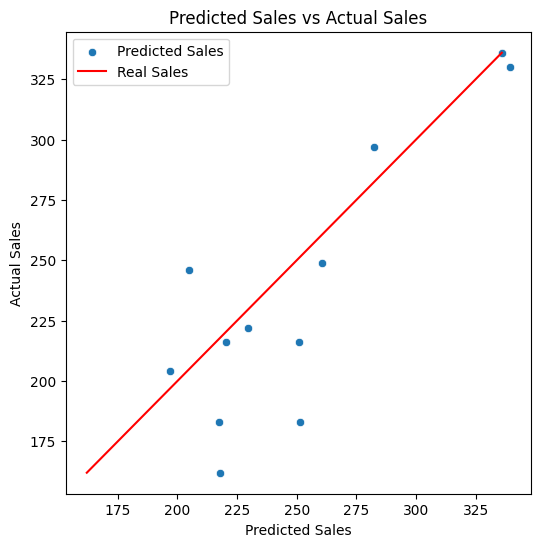

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Predicted Sales")
ax.set_ylabel("Actual Sales")
sns.scatterplot(x=y_pred, y=y_test, ax=ax, label="Predicted Sales")
sns.lineplot(x=y_test, y=y_test, color="red", ax=ax, label="Real Sales")

<Axes: title={'center': 'Predicted Sales vs Actual Sales'}, xlabel='Date', ylabel='Sales'>

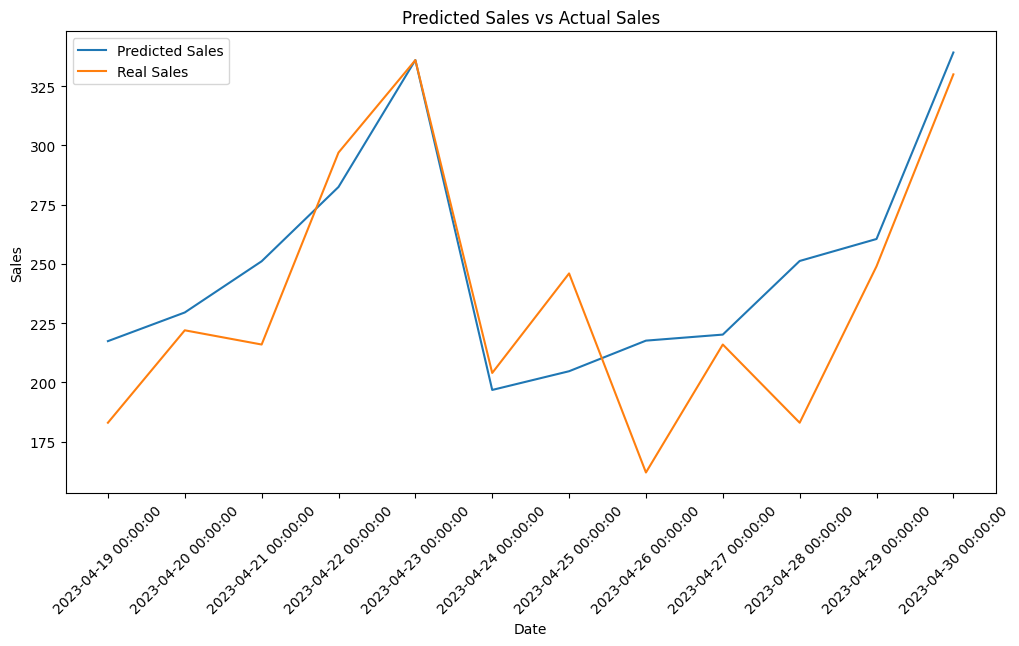

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_xticklabels(df_test["fecha_venta"], rotation=45)

dates = df_test["fecha_venta"].astype(str)
sns.lineplot(x=dates, y=y_pred, label="Predicted Sales")
sns.lineplot(x=dates, y=y_test, label="Real Sales")

## Deploy the model

In a terminal run the following command to deploy the model:

```bash
export MLFLOW_TRACKING_URI=http://localhost:5000
mlflow models serve -m models:/datahon_iv@production -p 5001 --env-manager local
```

You should see something like this:

```bash
[INFO] Starting gunicorn 21.2.0
[INFO] Listening at: http://127.0.0.1:5001 (236041)
[INFO] Using worker: sync
[INFO] Booting worker with pid: 236048
```

It means it's working correctly 🎉`

## Make requests to the model

The model is now deployed and ready to receive requests. We will make a request to the model using the test set.

- 👉 prepare the test set to be sent as JSON
- 👉 make a POST request to the model
- 👉 get the predictions from the response and show them

In [34]:
import requests
import json


URL = "http://127.0.0.1:5001/invocations"
headers = {"Content-Type": "application/json"}

df_send = df_test.copy()
df_send["fecha_venta"] = df_send["fecha_venta"].astype(str)

data = {
    "dataframe_split": {
        "columns": df_send.columns.tolist(),
        "index": df_send.index.to_list(),
        "data": df_send.values.tolist()
    }
}

response = requests.post(URL, headers=headers, data=json.dumps(data))
predictions = response.json()['predictions']

In [36]:
predictions, y_pred

([217.4310268853823,
  229.52529077052938,
  251.13125058801276,
  282.4805856091528,
  336.03527400483483,
  196.8343637902711,
  204.7322582883082,
  217.64097315178336,
  220.18986195101334,
  251.25007937561142,
  260.5304410400997,
  339.2225157400776],
 array([217.43102689, 229.52529077, 251.13125059, 282.48058561,
        336.035274  , 196.83436379, 204.73225829, 217.64097315,
        220.18986195, 251.25007938, 260.53044104, 339.22251574]))

## Push Results to Database

We push the results to the database so we can visualize them using other tools like Tableau, PowerBI, etc.

Prepare the dataframe to upload to the database.

In [58]:
dates = df_send["fecha_venta"].tolist()

# Create a dataframe with the data to store
df_article_prediction = pd.DataFrame({
    "fecha": dates,
    "cantidad": predictions,
    "articulo": [PRODUCT_ID] * len(predictions),  # repeat the article for each date
    "familia": [PRODUCT_FAMILY] * len(predictions),  # repeat the family for each date
})

df_article_prediction.head(5)

,fecha,cantidad,articulo,familia
0,2023-04-19,217.431027,3960,BOLLERIA
1,2023-04-20,229.525291,3960,BOLLERIA
2,2023-04-21,251.131251,3960,BOLLERIA
3,2023-04-22,282.480586,3960,BOLLERIA
4,2023-04-23,336.035274,3960,BOLLERIA


Push the dataframe to the database


In [59]:
# Define el nombre de la tabla
NAME = "AlejandroT"
table_name = f"Materials_Prediction_Group_AlejandroT"

try:
    # Conecta a la base de datos
    db = DatabaseConnection()  # Las credenciales se cargan automáticamente desde las variables de entorno

    # Inserta el DataFrame en la tabla
    db.insert_dataframe(df_article_prediction, table_name)

    # Cierra la conexión
    db.close_connection()
    print("Datos insertados correctamente en la base de datos.")
except Exception as e:
    print(f"Error al insertar datos en la base de datos: {e}")

Data inserted successfully into Materials_Prediction_Group_AlejandroT
Datos insertados correctamente en la base de datos.
